# Training an optimized MLP model

In [5]:
from google.colab import drive
drive.mount('/content/drive/')
!pwd
!p "/content/drive/My Drive/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content
/bin/bash: line 1: p: command not found


In [6]:
!pip install optuna

In [7]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May 25 12:38:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P0             49W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## 1. Dataset

In [8]:
import joblib, numpy as np, torch, optuna, gc
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from pathlib import Path


DRIVE_PROJECT = "/content/drive/My Drive/Project 3/"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

SUPER = joblib.load(DRIVE_PROJECT + "optimized_data_processing/super_data_payload.pkl")
train_df = SUPER["train_df"]
val_df = SUPER["val_df"]
FEATURE_SETS = SUPER["feature_sets"]
ALL_NUMERIC_COLS = SUPER["numeric_cols"]

CKPT_DIR = Path(DRIVE_PROJECT + "gru_ckpts")
CKPT_DIR.mkdir(exist_ok=True)

Running on cuda


## 2. Sliding windows

In [9]:
# Helper: build sliding windows
def build_windows(df, win_len, stride, feature_cols):
    data, labels = [], []
    for _, fl in df.groupby("flight_id"):
        X = fl[feature_cols].to_numpy(dtype=np.float32)
        y = fl["is_7700"].to_numpy(dtype=np.int8)  # chdanged from bool to int
        for i in range(0, len(X) - win_len + 1, stride):
            data.append(X[i : i + win_len])
            labels.append(int(y[i : i + win_len].any()))  # 1 if ANY emergency in window
    return np.stack(data), np.array(labels)


window_cache = {}


def get_windows(df, feat_key, win_len, stride):
    # Different DataFrames have different id() values
    cache_key = f"{id(df)}_{feat_key}_{win_len}_{stride}"
    if cache_key not in window_cache:
        if feat_key == "all_numeric":
            X_np, y_np = build_windows(df, win_len, stride, ALL_NUMERIC_COLS)
        else:
            X_np, y_np = build_windows(df, win_len, stride, FEATURE_SETS[feat_key])
        X_t = torch.tensor(X_np, dtype=torch.float32)
        y_t = torch.tensor(y_np, dtype=torch.float32).unsqueeze(1)
        window_cache[cache_key] = (X_t, y_t)
    return window_cache[cache_key]

 ## 3. Model definition

In [10]:
class MLPClassifier(nn.Module):
    def __init__(self, in_dim, hidden1, hidden2, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),  # (B, T, F) → (B, T*F)
            nn.Linear(in_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2, 1),  # binary logit
        )

    def forward(self, x):
        return self.net(x)

 ## 4. Optuna objective

In [11]:
def objective(trial: optuna.trial.Trial):
    print(f"---- Trial #{trial.number}  --  started ----------------------------")

    # -- data hyper‐params
    feat_key = trial.suggest_categorical("features", ["all_numeric", "baseline"])
    win_len = trial.suggest_categorical("win_len", [30, 60, 120])
    stride = trial.suggest_categorical("stride", [10, 20])

    X_tr, y_tr = get_windows(train_df, feat_key, win_len, stride)
    X_va, y_va = get_windows(val_df, feat_key, win_len, stride)

    BATCH = 256
    train_loader = DataLoader(
        TensorDataset(X_tr, y_tr),
        batch_size=BATCH,
        shuffle=True,
        drop_last=True,
        pin_memory=True if DEVICE == "cuda" else False,
    )
    val_loader = DataLoader(
        TensorDataset(X_va, y_va),
        batch_size=BATCH,
        shuffle=False,
        pin_memory=True if DEVICE == "cuda" else False,
    )

    # -- model hyper‐params
    hidden1 = trial.suggest_categorical("hidden1", [128, 256, 512])
    hidden2 = trial.suggest_categorical("hidden2", [32, 64, 128])
    dropout = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)

    # build model
    in_dim = X_tr.shape[1] * X_tr.shape[2]
    print(
        f"Using features: {feat_key}, win_len: {win_len}, stride: {stride}"
        f", hidden1: {hidden1}, hidden2: {hidden2}, dropout: {dropout}, lr: {lr}, in_dim: {in_dim}"
    )
    model = MLPClassifier(in_dim, hidden1, hidden2, dropout).to(DEVICE)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optim, mode="max", factor=0.5, patience=1
    )

    # -- training loops & logging
    lr_curve, train_loss_curve, val_f1_curve = [], [], []
    EPOCHS = 10
    for ep in range(1, EPOCHS + 1):
        print(f"Epoch {ep}/{EPOCHS}  —  LR: {optim.param_groups[0]['lr']:.6f}")
        # train
        model.train()
        running = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            loss = nn.functional.binary_cross_entropy_with_logits(logits, yb)
            optim.zero_grad()
            loss.backward()
            optim.step()
            running += loss.item() * yb.size(0)
        tr_loss = running / len(train_loader.dataset)
        train_loss_curve.append(tr_loss)

        # validate
        model.eval()
        preds, gts = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                logits = model(xb.to(DEVICE))
                preds.extend((torch.sigmoid(logits) > 0.5).cpu().numpy().ravel())
                gts.extend(yb.cpu().numpy().ravel())
        val_f1 = f1_score(gts, preds)
        val_f1_curve.append(val_f1)

        # logging & pruning & LR‐decay
        lr_curve.append(optim.param_groups[0]["lr"])
        trial.report(val_f1, ep)
        if trial.should_prune():
            print(f"Trial #{trial.number} pruned at epoch {ep} with F1: {val_f1:.4f}")
            raise optuna.TrialPruned()
        sched.step(val_f1)

    # -- save checkpoint & attrs
    ckpt = CKPT_DIR / f"trial_{trial.number}.pt"
    torch.save(model.state_dict(), ckpt)
    trial.set_user_attr("ckpt", str(ckpt))
    trial.set_user_attr("features", feat_key)
    trial.set_user_attr("win_len", win_len)
    trial.set_user_attr("stride", stride)
    trial.set_user_attr("lr_curve", lr_curve)
    trial.set_user_attr("train_loss_curve", train_loss_curve)
    trial.set_user_attr("val_f1_curve", val_f1_curve)

    # cleanup
    del model, X_tr, y_tr, X_va, y_va, train_loader, val_loader
    torch.cuda.empty_cache()
    gc.collect()

    return val_f1_curve[-1]

 ## 5. Launch the study

n_startup_trials=5, n_warmup_steps=3

In [12]:
TRIALS = 72
optuna.logging.set_verbosity(optuna.logging.INFO)
DB = f"sqlite:///{DRIVE_PROJECT}/mlp_hpo.db"

study = optuna.create_study(
    study_name="mlp_hpo",
    direction="maximize",
    storage=DB,
    load_if_exists=True,
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3),
)
study.optimize(objective, n_trials=TRIALS)

print("Best F1:", study.best_value)
print("Best params:", study.best_params)

[I 2025-05-25 12:38:30,451] A new study created in RDB with name: mlp_hpo


---- Trial #0  --  started ----------------------------
Using features: baseline, win_len: 60, stride: 10, hidden1: 512, hidden2: 64, dropout: 0.0, lr: 0.001925166558779066, in_dim: 600
Epoch 1/10  —  LR: 0.001925
Epoch 2/10  —  LR: 0.001925
Epoch 3/10  —  LR: 0.001925
Epoch 4/10  —  LR: 0.000963
Epoch 5/10  —  LR: 0.000963
Epoch 6/10  —  LR: 0.000481
Epoch 7/10  —  LR: 0.000481
Epoch 8/10  —  LR: 0.000241
Epoch 9/10  —  LR: 0.000241
Epoch 10/10  —  LR: 0.000120


[I 2025-05-25 12:39:36,808] Trial 0 finished with value: 0.6196935844238749 and parameters: {'features': 'baseline', 'win_len': 60, 'stride': 10, 'hidden1': 512, 'hidden2': 64, 'dropout': 0.0, 'lr': 0.001925166558779066}. Best is trial 0 with value: 0.6196935844238749.


---- Trial #1  --  started ----------------------------
Using features: baseline, win_len: 60, stride: 20, hidden1: 256, hidden2: 32, dropout: 0.4, lr: 0.0002955708763572358, in_dim: 600
Epoch 1/10  —  LR: 0.000296
Epoch 2/10  —  LR: 0.000296
Epoch 3/10  —  LR: 0.000296
Epoch 4/10  —  LR: 0.000296
Epoch 5/10  —  LR: 0.000296
Epoch 6/10  —  LR: 0.000296
Epoch 7/10  —  LR: 0.000148
Epoch 8/10  —  LR: 0.000148
Epoch 9/10  —  LR: 0.000074
Epoch 10/10  —  LR: 0.000074


[I 2025-05-25 12:40:08,735] Trial 1 finished with value: 0.5741568468102397 and parameters: {'features': 'baseline', 'win_len': 60, 'stride': 20, 'hidden1': 256, 'hidden2': 32, 'dropout': 0.4, 'lr': 0.0002955708763572358}. Best is trial 0 with value: 0.6196935844238749.


---- Trial #2  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden1: 512, hidden2: 32, dropout: 0.2, lr: 0.0001247970403527792, in_dim: 2040
Epoch 1/10  —  LR: 0.000125
Epoch 2/10  —  LR: 0.000125
Epoch 3/10  —  LR: 0.000125
Epoch 4/10  —  LR: 0.000125
Epoch 5/10  —  LR: 0.000062
Epoch 6/10  —  LR: 0.000062
Epoch 7/10  —  LR: 0.000031
Epoch 8/10  —  LR: 0.000031
Epoch 9/10  —  LR: 0.000016
Epoch 10/10  —  LR: 0.000016


[I 2025-05-25 12:41:20,975] Trial 2 finished with value: 0.6134641873278237 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden1': 512, 'hidden2': 32, 'dropout': 0.2, 'lr': 0.0001247970403527792}. Best is trial 0 with value: 0.6196935844238749.


---- Trial #3  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 20, hidden1: 128, hidden2: 128, dropout: 0.0, lr: 0.00026468524231368715, in_dim: 510
Epoch 1/10  —  LR: 0.000265
Epoch 2/10  —  LR: 0.000265
Epoch 3/10  —  LR: 0.000265
Epoch 4/10  —  LR: 0.000265
Epoch 5/10  —  LR: 0.000265
Epoch 6/10  —  LR: 0.000132
Epoch 7/10  —  LR: 0.000132
Epoch 8/10  —  LR: 0.000066
Epoch 9/10  —  LR: 0.000066
Epoch 10/10  —  LR: 0.000033


[I 2025-05-25 12:41:51,197] Trial 3 finished with value: 0.5836569306094884 and parameters: {'features': 'all_numeric', 'win_len': 30, 'stride': 20, 'hidden1': 128, 'hidden2': 128, 'dropout': 0.0, 'lr': 0.00026468524231368715}. Best is trial 0 with value: 0.6196935844238749.


---- Trial #4  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden1: 256, hidden2: 32, dropout: 0.5, lr: 0.0035425030495094306, in_dim: 2040
Epoch 1/10  —  LR: 0.003543
Epoch 2/10  —  LR: 0.003543
Epoch 3/10  —  LR: 0.003543
Epoch 4/10  —  LR: 0.001771
Epoch 5/10  —  LR: 0.001771
Epoch 6/10  —  LR: 0.000886
Epoch 7/10  —  LR: 0.000886
Epoch 8/10  —  LR: 0.000443
Epoch 9/10  —  LR: 0.000443
Epoch 10/10  —  LR: 0.000221


[I 2025-05-25 12:42:28,590] Trial 4 finished with value: 0.4493927125506073 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden1': 256, 'hidden2': 32, 'dropout': 0.5, 'lr': 0.0035425030495094306}. Best is trial 0 with value: 0.6196935844238749.


---- Trial #5  --  started ----------------------------
Using features: baseline, win_len: 60, stride: 20, hidden1: 512, hidden2: 32, dropout: 0.1, lr: 0.0020764401054895014, in_dim: 600
Epoch 1/10  —  LR: 0.002076
Epoch 2/10  —  LR: 0.002076
Epoch 3/10  —  LR: 0.002076


[I 2025-05-25 12:42:37,397] Trial 5 pruned. 


Trial #5 pruned at epoch 3 with F1: 0.5468
---- Trial #6  --  started ----------------------------
Using features: baseline, win_len: 60, stride: 10, hidden1: 128, hidden2: 32, dropout: 0.1, lr: 0.00015037173707199014, in_dim: 600
Epoch 1/10  —  LR: 0.000150
Epoch 2/10  —  LR: 0.000150
Epoch 3/10  —  LR: 0.000150
Epoch 4/10  —  LR: 0.000150
Epoch 5/10  —  LR: 0.000150
Epoch 6/10  —  LR: 0.000150
Epoch 7/10  —  LR: 0.000150
Epoch 8/10  —  LR: 0.000150
Epoch 9/10  —  LR: 0.000150
Epoch 10/10  —  LR: 0.000150


[I 2025-05-25 12:43:35,365] Trial 6 finished with value: 0.608417238909719 and parameters: {'features': 'baseline', 'win_len': 60, 'stride': 10, 'hidden1': 128, 'hidden2': 32, 'dropout': 0.1, 'lr': 0.00015037173707199014}. Best is trial 0 with value: 0.6196935844238749.


---- Trial #7  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 10, hidden1: 256, hidden2: 32, dropout: 0.4, lr: 0.0022679308877355904, in_dim: 1020
Epoch 1/10  —  LR: 0.002268
Epoch 2/10  —  LR: 0.002268
Epoch 3/10  —  LR: 0.002268


[I 2025-05-25 12:43:57,186] Trial 7 pruned. 


Trial #7 pruned at epoch 3 with F1: 0.5330
---- Trial #8  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden1: 512, hidden2: 64, dropout: 0.5, lr: 0.0005522124519222526, in_dim: 1200
Epoch 1/10  —  LR: 0.000552
Epoch 2/10  —  LR: 0.000552
Epoch 3/10  —  LR: 0.000552


[I 2025-05-25 12:44:08,825] Trial 8 pruned. 


Trial #8 pruned at epoch 3 with F1: 0.5283
---- Trial #9  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 20, hidden1: 512, hidden2: 128, dropout: 0.2, lr: 0.0017538300163857058, in_dim: 510
Epoch 1/10  —  LR: 0.001754
Epoch 2/10  —  LR: 0.001754
Epoch 3/10  —  LR: 0.001754
Epoch 4/10  —  LR: 0.000877
Epoch 5/10  —  LR: 0.000877
Epoch 6/10  —  LR: 0.000877
Epoch 7/10  —  LR: 0.000438
Epoch 8/10  —  LR: 0.000438
Epoch 9/10  —  LR: 0.000219
Epoch 10/10  —  LR: 0.000219


[I 2025-05-25 12:44:37,743] Trial 9 finished with value: 0.616247865333008 and parameters: {'features': 'all_numeric', 'win_len': 30, 'stride': 20, 'hidden1': 512, 'hidden2': 128, 'dropout': 0.2, 'lr': 0.0017538300163857058}. Best is trial 0 with value: 0.6196935844238749.


---- Trial #10  --  started ----------------------------
Using features: baseline, win_len: 60, stride: 10, hidden1: 512, hidden2: 64, dropout: 0.0, lr: 0.0010216563505826015, in_dim: 600
Epoch 1/10  —  LR: 0.001022
Epoch 2/10  —  LR: 0.001022
Epoch 3/10  —  LR: 0.001022
Epoch 4/10  —  LR: 0.001022
Epoch 5/10  —  LR: 0.001022
Epoch 6/10  —  LR: 0.001022
Epoch 7/10  —  LR: 0.000511
Epoch 8/10  —  LR: 0.000511
Epoch 9/10  —  LR: 0.000511
Epoch 10/10  —  LR: 0.000255


[I 2025-05-25 12:45:34,317] Trial 10 finished with value: 0.5931150808862992 and parameters: {'features': 'baseline', 'win_len': 60, 'stride': 10, 'hidden1': 512, 'hidden2': 64, 'dropout': 0.0, 'lr': 0.0010216563505826015}. Best is trial 0 with value: 0.6196935844238749.


---- Trial #11  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 10, hidden1: 512, hidden2: 128, dropout: 0.2, lr: 0.001130853796316479, in_dim: 510
Epoch 1/10  —  LR: 0.001131
Epoch 2/10  —  LR: 0.001131
Epoch 3/10  —  LR: 0.001131
Epoch 4/10  —  LR: 0.001131
Epoch 5/10  —  LR: 0.001131
Epoch 6/10  —  LR: 0.001131
Epoch 7/10  —  LR: 0.000565
Epoch 8/10  —  LR: 0.000565
Epoch 9/10  —  LR: 0.000283
Epoch 10/10  —  LR: 0.000283


[I 2025-05-25 12:46:34,638] Trial 11 finished with value: 0.6238320543914755 and parameters: {'features': 'all_numeric', 'win_len': 30, 'stride': 10, 'hidden1': 512, 'hidden2': 128, 'dropout': 0.2, 'lr': 0.001130853796316479}. Best is trial 11 with value: 0.6238320543914755.


---- Trial #12  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 10, hidden1: 512, hidden2: 128, dropout: 0.30000000000000004, lr: 0.00092368056830032, in_dim: 510
Epoch 1/10  —  LR: 0.000924
Epoch 2/10  —  LR: 0.000924
Epoch 3/10  —  LR: 0.000924
Epoch 4/10  —  LR: 0.000462
Epoch 5/10  —  LR: 0.000462
Epoch 6/10  —  LR: 0.000462
Epoch 7/10  —  LR: 0.000231
Epoch 8/10  —  LR: 0.000231
Epoch 9/10  —  LR: 0.000115
Epoch 10/10  —  LR: 0.000115


[I 2025-05-25 12:47:31,876] Trial 12 finished with value: 0.6298674904479311 and parameters: {'features': 'all_numeric', 'win_len': 30, 'stride': 10, 'hidden1': 512, 'hidden2': 128, 'dropout': 0.30000000000000004, 'lr': 0.00092368056830032}. Best is trial 12 with value: 0.6298674904479311.


---- Trial #13  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 10, hidden1: 512, hidden2: 128, dropout: 0.30000000000000004, lr: 0.0007776580370991685, in_dim: 510
Epoch 1/10  —  LR: 0.000778
Epoch 2/10  —  LR: 0.000778
Epoch 3/10  —  LR: 0.000778
Epoch 4/10  —  LR: 0.000778
Epoch 5/10  —  LR: 0.000778
Epoch 6/10  —  LR: 0.000389
Epoch 7/10  —  LR: 0.000389
Epoch 8/10  —  LR: 0.000194
Epoch 9/10  —  LR: 0.000194
Epoch 10/10  —  LR: 0.000097


[I 2025-05-25 12:48:29,257] Trial 13 finished with value: 0.6025385764061723 and parameters: {'features': 'all_numeric', 'win_len': 30, 'stride': 10, 'hidden1': 512, 'hidden2': 128, 'dropout': 0.30000000000000004, 'lr': 0.0007776580370991685}. Best is trial 12 with value: 0.6298674904479311.


---- Trial #14  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 10, hidden1: 512, hidden2: 128, dropout: 0.30000000000000004, lr: 0.000490281990625108, in_dim: 510
Epoch 1/10  —  LR: 0.000490
Epoch 2/10  —  LR: 0.000490
Epoch 3/10  —  LR: 0.000490
Epoch 4/10  —  LR: 0.000245
Epoch 5/10  —  LR: 0.000245
Epoch 6/10  —  LR: 0.000123
Epoch 7/10  —  LR: 0.000123
Epoch 8/10  —  LR: 0.000061
Epoch 9/10  —  LR: 0.000061
Epoch 10/10  —  LR: 0.000031


[I 2025-05-25 12:49:26,911] Trial 14 finished with value: 0.6265196952504458 and parameters: {'features': 'all_numeric', 'win_len': 30, 'stride': 10, 'hidden1': 512, 'hidden2': 128, 'dropout': 0.30000000000000004, 'lr': 0.000490281990625108}. Best is trial 12 with value: 0.6298674904479311.


---- Trial #15  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 10, hidden1: 128, hidden2: 128, dropout: 0.30000000000000004, lr: 0.0004179036004091992, in_dim: 510
Epoch 1/10  —  LR: 0.000418
Epoch 2/10  —  LR: 0.000418
Epoch 3/10  —  LR: 0.000418


[I 2025-05-25 12:49:43,964] Trial 15 pruned. 


Trial #15 pruned at epoch 3 with F1: 0.5788
---- Trial #16  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 10, hidden1: 512, hidden2: 128, dropout: 0.4, lr: 0.00047400277612799597, in_dim: 510
Epoch 1/10  —  LR: 0.000474
Epoch 2/10  —  LR: 0.000474
Epoch 3/10  —  LR: 0.000474
Epoch 4/10  —  LR: 0.000474


[I 2025-05-25 12:50:06,954] Trial 16 pruned. 


Trial #16 pruned at epoch 4 with F1: 0.5683
---- Trial #17  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 10, hidden1: 512, hidden2: 128, dropout: 0.30000000000000004, lr: 0.00022260253761000845, in_dim: 510
Epoch 1/10  —  LR: 0.000223
Epoch 2/10  —  LR: 0.000223
Epoch 3/10  —  LR: 0.000223
Epoch 4/10  —  LR: 0.000223
Epoch 5/10  —  LR: 0.000111
Epoch 6/10  —  LR: 0.000111
Epoch 7/10  —  LR: 0.000056
Epoch 8/10  —  LR: 0.000056
Epoch 9/10  —  LR: 0.000028
Epoch 10/10  —  LR: 0.000028


[I 2025-05-25 12:51:04,558] Trial 17 finished with value: 0.6001509813789633 and parameters: {'features': 'all_numeric', 'win_len': 30, 'stride': 10, 'hidden1': 512, 'hidden2': 128, 'dropout': 0.30000000000000004, 'lr': 0.00022260253761000845}. Best is trial 12 with value: 0.6298674904479311.


---- Trial #18  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 10, hidden1: 256, hidden2: 128, dropout: 0.4, lr: 0.0008876085324943659, in_dim: 510
Epoch 1/10  —  LR: 0.000888
Epoch 2/10  —  LR: 0.000888
Epoch 3/10  —  LR: 0.000888


[I 2025-05-25 12:51:21,629] Trial 18 pruned. 


Trial #18 pruned at epoch 3 with F1: 0.5873
---- Trial #19  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 10, hidden1: 128, hidden2: 128, dropout: 0.30000000000000004, lr: 0.00404113975126703, in_dim: 510
Epoch 1/10  —  LR: 0.004041
Epoch 2/10  —  LR: 0.004041
Epoch 3/10  —  LR: 0.004041


[I 2025-05-25 12:51:38,880] Trial 19 pruned. 


Trial #19 pruned at epoch 3 with F1: 0.5726
---- Trial #20  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 10, hidden1: 512, hidden2: 128, dropout: 0.1, lr: 0.0006150035778280939, in_dim: 510
Epoch 1/10  —  LR: 0.000615
Epoch 2/10  —  LR: 0.000615
Epoch 3/10  —  LR: 0.000615
Epoch 4/10  —  LR: 0.000615
Epoch 5/10  —  LR: 0.000615
Epoch 6/10  —  LR: 0.000308
Epoch 7/10  —  LR: 0.000308
Epoch 8/10  —  LR: 0.000154
Epoch 9/10  —  LR: 0.000154
Epoch 10/10  —  LR: 0.000077


[I 2025-05-25 12:52:36,622] Trial 20 finished with value: 0.6036054618208819 and parameters: {'features': 'all_numeric', 'win_len': 30, 'stride': 10, 'hidden1': 512, 'hidden2': 128, 'dropout': 0.1, 'lr': 0.0006150035778280939}. Best is trial 12 with value: 0.6298674904479311.


---- Trial #21  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 10, hidden1: 512, hidden2: 128, dropout: 0.2, lr: 0.0012203459981438472, in_dim: 510
Epoch 1/10  —  LR: 0.001220
Epoch 2/10  —  LR: 0.001220
Epoch 3/10  —  LR: 0.001220
Epoch 4/10  —  LR: 0.001220
Epoch 5/10  —  LR: 0.000610
Epoch 6/10  —  LR: 0.000610
Epoch 7/10  —  LR: 0.000305
Epoch 8/10  —  LR: 0.000305
Epoch 9/10  —  LR: 0.000153
Epoch 10/10  —  LR: 0.000153


[I 2025-05-25 12:53:33,853] Trial 21 finished with value: 0.599807984638771 and parameters: {'features': 'all_numeric', 'win_len': 30, 'stride': 10, 'hidden1': 512, 'hidden2': 128, 'dropout': 0.2, 'lr': 0.0012203459981438472}. Best is trial 12 with value: 0.6298674904479311.


---- Trial #22  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 10, hidden1: 512, hidden2: 128, dropout: 0.2, lr: 0.0012610819950291173, in_dim: 510
Epoch 1/10  —  LR: 0.001261
Epoch 2/10  —  LR: 0.001261
Epoch 3/10  —  LR: 0.001261
Epoch 4/10  —  LR: 0.001261
Epoch 5/10  —  LR: 0.001261
Epoch 6/10  —  LR: 0.001261
Epoch 7/10  —  LR: 0.001261
Epoch 8/10  —  LR: 0.000631
Epoch 9/10  —  LR: 0.000631
Epoch 10/10  —  LR: 0.000315


[I 2025-05-25 12:54:31,236] Trial 22 finished with value: 0.6051383562208751 and parameters: {'features': 'all_numeric', 'win_len': 30, 'stride': 10, 'hidden1': 512, 'hidden2': 128, 'dropout': 0.2, 'lr': 0.0012610819950291173}. Best is trial 12 with value: 0.6298674904479311.


---- Trial #23  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 10, hidden1: 512, hidden2: 128, dropout: 0.30000000000000004, lr: 0.0003859685441218909, in_dim: 510
Epoch 1/10  —  LR: 0.000386
Epoch 2/10  —  LR: 0.000386
Epoch 3/10  —  LR: 0.000386
Epoch 4/10  —  LR: 0.000193
Epoch 5/10  —  LR: 0.000193
Epoch 6/10  —  LR: 0.000096
Epoch 7/10  —  LR: 0.000096
Epoch 8/10  —  LR: 0.000048
Epoch 9/10  —  LR: 0.000048
Epoch 10/10  —  LR: 0.000024


[I 2025-05-25 12:55:28,632] Trial 23 finished with value: 0.5999829307843305 and parameters: {'features': 'all_numeric', 'win_len': 30, 'stride': 10, 'hidden1': 512, 'hidden2': 128, 'dropout': 0.30000000000000004, 'lr': 0.0003859685441218909}. Best is trial 12 with value: 0.6298674904479311.


---- Trial #24  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 10, hidden1: 512, hidden2: 128, dropout: 0.2, lr: 0.0007252059742777075, in_dim: 510
Epoch 1/10  —  LR: 0.000725
Epoch 2/10  —  LR: 0.000725
Epoch 3/10  —  LR: 0.000725
Epoch 4/10  —  LR: 0.000725
Epoch 5/10  —  LR: 0.000725
Epoch 6/10  —  LR: 0.000363
Epoch 7/10  —  LR: 0.000363
Epoch 8/10  —  LR: 0.000363
Epoch 9/10  —  LR: 0.000363


[I 2025-05-25 12:56:19,996] Trial 24 pruned. 


Trial #24 pruned at epoch 9 with F1: 0.6023
---- Trial #25  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden1: 512, hidden2: 64, dropout: 0.1, lr: 0.0013698910328471638, in_dim: 2040
Epoch 1/10  —  LR: 0.001370
Epoch 2/10  —  LR: 0.001370
Epoch 3/10  —  LR: 0.001370
Epoch 4/10  —  LR: 0.001370
Epoch 5/10  —  LR: 0.001370
Epoch 6/10  —  LR: 0.001370
Epoch 7/10  —  LR: 0.001370
Epoch 8/10  —  LR: 0.000685
Epoch 9/10  —  LR: 0.000685
Epoch 10/10  —  LR: 0.000342


[I 2025-05-25 12:57:30,104] Trial 25 finished with value: 0.6617207131745841 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden1': 512, 'hidden2': 64, 'dropout': 0.1, 'lr': 0.0013698910328471638}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #26  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden1: 512, hidden2: 64, dropout: 0.1, lr: 0.0014842509250744091, in_dim: 2040
Epoch 1/10  —  LR: 0.001484
Epoch 2/10  —  LR: 0.001484
Epoch 3/10  —  LR: 0.001484
Epoch 4/10  —  LR: 0.001484
Epoch 5/10  —  LR: 0.001484
Epoch 6/10  —  LR: 0.001484
Epoch 7/10  —  LR: 0.000742
Epoch 8/10  —  LR: 0.000742
Epoch 9/10  —  LR: 0.000371
Epoch 10/10  —  LR: 0.000371


[I 2025-05-25 12:58:39,603] Trial 26 finished with value: 0.6073701706733693 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden1': 512, 'hidden2': 64, 'dropout': 0.1, 'lr': 0.0014842509250744091}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #27  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden1: 512, hidden2: 64, dropout: 0.4, lr: 0.0028023965875341346, in_dim: 2040
Epoch 1/10  —  LR: 0.002802
Epoch 2/10  —  LR: 0.002802
Epoch 3/10  —  LR: 0.002802
Epoch 4/10  —  LR: 0.002802
Epoch 5/10  —  LR: 0.002802
Epoch 6/10  —  LR: 0.002802
Epoch 7/10  —  LR: 0.002802
Epoch 8/10  —  LR: 0.001401
Epoch 9/10  —  LR: 0.001401
Epoch 10/10  —  LR: 0.000701


[I 2025-05-25 12:59:48,871] Trial 27 finished with value: 0.6411827489425623 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden1': 512, 'hidden2': 64, 'dropout': 0.4, 'lr': 0.0028023965875341346}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #28  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden1: 256, hidden2: 64, dropout: 0.5, lr: 0.002384484131828196, in_dim: 2040
Epoch 1/10  —  LR: 0.002384
Epoch 2/10  —  LR: 0.002384
Epoch 3/10  —  LR: 0.002384


[I 2025-05-25 13:00:09,475] Trial 28 pruned. 


Trial #28 pruned at epoch 3 with F1: 0.4608
---- Trial #29  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 10, hidden1: 128, hidden2: 64, dropout: 0.4, lr: 0.003092077681698592, in_dim: 1200
Epoch 1/10  —  LR: 0.003092
Epoch 2/10  —  LR: 0.003092
Epoch 3/10  —  LR: 0.003092


[I 2025-05-25 13:00:31,365] Trial 29 pruned. 


Trial #29 pruned at epoch 3 with F1: 0.5082
---- Trial #30  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden1: 512, hidden2: 64, dropout: 0.0, lr: 0.002721759386562148, in_dim: 2040
Epoch 1/10  —  LR: 0.002722
Epoch 2/10  —  LR: 0.002722
Epoch 3/10  —  LR: 0.002722
Epoch 4/10  —  LR: 0.002722
Epoch 5/10  —  LR: 0.002722
Epoch 6/10  —  LR: 0.001361
Epoch 7/10  —  LR: 0.001361
Epoch 8/10  —  LR: 0.000680
Epoch 9/10  —  LR: 0.000680
Epoch 10/10  —  LR: 0.000340


[I 2025-05-25 13:01:39,237] Trial 30 finished with value: 0.629041990558336 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden1': 512, 'hidden2': 64, 'dropout': 0.0, 'lr': 0.002721759386562148}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #31  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden1: 512, hidden2: 64, dropout: 0.0, lr: 0.0032824674324633692, in_dim: 2040
Epoch 1/10  —  LR: 0.003282
Epoch 2/10  —  LR: 0.003282
Epoch 3/10  —  LR: 0.003282
Epoch 4/10  —  LR: 0.001641
Epoch 5/10  —  LR: 0.001641
Epoch 6/10  —  LR: 0.000821
Epoch 7/10  —  LR: 0.000821
Epoch 8/10  —  LR: 0.000410
Epoch 9/10  —  LR: 0.000410
Epoch 10/10  —  LR: 0.000205


[I 2025-05-25 13:02:47,060] Trial 31 finished with value: 0.5954682424764216 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden1': 512, 'hidden2': 64, 'dropout': 0.0, 'lr': 0.0032824674324633692}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #32  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden1: 512, hidden2: 64, dropout: 0.0, lr: 0.0017047679509055752, in_dim: 2040
Epoch 1/10  —  LR: 0.001705
Epoch 2/10  —  LR: 0.001705
Epoch 3/10  —  LR: 0.001705
Epoch 4/10  —  LR: 0.001705
Epoch 5/10  —  LR: 0.001705
Epoch 6/10  —  LR: 0.001705
Epoch 7/10  —  LR: 0.001705
Epoch 8/10  —  LR: 0.001705
Epoch 9/10  —  LR: 0.000852
Epoch 10/10  —  LR: 0.000852


[I 2025-05-25 13:03:54,820] Trial 32 finished with value: 0.6298686508237795 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden1': 512, 'hidden2': 64, 'dropout': 0.0, 'lr': 0.0017047679509055752}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #33  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden1: 512, hidden2: 64, dropout: 0.1, lr: 0.004587648324912342, in_dim: 2040
Epoch 1/10  —  LR: 0.004588
Epoch 2/10  —  LR: 0.004588
Epoch 3/10  —  LR: 0.004588
Epoch 4/10  —  LR: 0.002294
Epoch 5/10  —  LR: 0.002294
Epoch 6/10  —  LR: 0.001147
Epoch 7/10  —  LR: 0.001147
Epoch 8/10  —  LR: 0.000573
Epoch 9/10  —  LR: 0.000573
Epoch 10/10  —  LR: 0.000287


[I 2025-05-25 13:05:04,262] Trial 33 finished with value: 0.6303113586229342 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden1': 512, 'hidden2': 64, 'dropout': 0.1, 'lr': 0.004587648324912342}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #34  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden1: 512, hidden2: 64, dropout: 0.1, lr: 0.004366817247700153, in_dim: 2040
Epoch 1/10  —  LR: 0.004367
Epoch 2/10  —  LR: 0.004367
Epoch 3/10  —  LR: 0.004367


[I 2025-05-25 13:05:14,707] Trial 34 pruned. 


Trial #34 pruned at epoch 3 with F1: 0.5336
---- Trial #35  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden1: 512, hidden2: 64, dropout: 0.0, lr: 0.004994712029623225, in_dim: 2040
Epoch 1/10  —  LR: 0.004995
Epoch 2/10  —  LR: 0.004995
Epoch 3/10  —  LR: 0.004995
Epoch 4/10  —  LR: 0.004995
Epoch 5/10  —  LR: 0.004995
Epoch 6/10  —  LR: 0.004995
Epoch 7/10  —  LR: 0.002497
Epoch 8/10  —  LR: 0.002497
Epoch 9/10  —  LR: 0.001249
Epoch 10/10  —  LR: 0.001249


[I 2025-05-25 13:06:22,571] Trial 35 finished with value: 0.628185010834641 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden1': 512, 'hidden2': 64, 'dropout': 0.0, 'lr': 0.004994712029623225}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #36  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden1: 256, hidden2: 64, dropout: 0.1, lr: 0.0017498342699353224, in_dim: 1200
Epoch 1/10  —  LR: 0.001750
Epoch 2/10  —  LR: 0.001750
Epoch 3/10  —  LR: 0.001750
Epoch 4/10  —  LR: 0.001750
Epoch 5/10  —  LR: 0.001750
Epoch 6/10  —  LR: 0.001750
Epoch 7/10  —  LR: 0.001750
Epoch 8/10  —  LR: 0.000875
Epoch 9/10  —  LR: 0.000875
Epoch 10/10  —  LR: 0.000875


[I 2025-05-25 13:06:53,991] Trial 36 finished with value: 0.6549022590705104 and parameters: {'features': 'baseline', 'win_len': 120, 'stride': 20, 'hidden1': 256, 'hidden2': 64, 'dropout': 0.1, 'lr': 0.0017498342699353224}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #37  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden1: 256, hidden2: 64, dropout: 0.1, lr: 0.002802038076770962, in_dim: 1200
Epoch 1/10  —  LR: 0.002802
Epoch 2/10  —  LR: 0.002802
Epoch 3/10  —  LR: 0.002802
Epoch 4/10  —  LR: 0.001401
Epoch 5/10  —  LR: 0.001401
Epoch 6/10  —  LR: 0.000701
Epoch 7/10  —  LR: 0.000701
Epoch 8/10  —  LR: 0.000350
Epoch 9/10  —  LR: 0.000350
Epoch 10/10  —  LR: 0.000175


[I 2025-05-25 13:07:25,925] Trial 37 finished with value: 0.5471223021582734 and parameters: {'features': 'baseline', 'win_len': 120, 'stride': 20, 'hidden1': 256, 'hidden2': 64, 'dropout': 0.1, 'lr': 0.002802038076770962}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #38  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden1: 256, hidden2: 64, dropout: 0.1, lr: 0.002003768295833615, in_dim: 1200
Epoch 1/10  —  LR: 0.002004
Epoch 2/10  —  LR: 0.002004
Epoch 3/10  —  LR: 0.002004


[I 2025-05-25 13:07:35,472] Trial 38 pruned. 


Trial #38 pruned at epoch 3 with F1: 0.6016
---- Trial #39  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden1: 256, hidden2: 64, dropout: 0.1, lr: 0.0014325737125670673, in_dim: 1200
Epoch 1/10  —  LR: 0.001433
Epoch 2/10  —  LR: 0.001433
Epoch 3/10  —  LR: 0.001433
Epoch 4/10  —  LR: 0.000716
Epoch 5/10  —  LR: 0.000716
Epoch 6/10  —  LR: 0.000358
Epoch 7/10  —  LR: 0.000358
Epoch 8/10  —  LR: 0.000358
Epoch 9/10  —  LR: 0.000358
Epoch 10/10  —  LR: 0.000358


[I 2025-05-25 13:08:07,097] Trial 39 finished with value: 0.6159242943383912 and parameters: {'features': 'baseline', 'win_len': 120, 'stride': 20, 'hidden1': 256, 'hidden2': 64, 'dropout': 0.1, 'lr': 0.0014325737125670673}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #40  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden1: 256, hidden2: 64, dropout: 0.2, lr: 0.003478563002757065, in_dim: 1200
Epoch 1/10  —  LR: 0.003479
Epoch 2/10  —  LR: 0.003479
Epoch 3/10  —  LR: 0.003479


[I 2025-05-25 13:08:16,789] Trial 40 pruned. 


Trial #40 pruned at epoch 3 with F1: 0.5339
---- Trial #41  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden1: 256, hidden2: 64, dropout: 0.0, lr: 0.0016303896595601748, in_dim: 1200
Epoch 1/10  —  LR: 0.001630
Epoch 2/10  —  LR: 0.001630
Epoch 3/10  —  LR: 0.001630
Epoch 4/10  —  LR: 0.001630
Epoch 5/10  —  LR: 0.001630
Epoch 6/10  —  LR: 0.000815
Epoch 7/10  —  LR: 0.000815
Epoch 8/10  —  LR: 0.000408
Epoch 9/10  —  LR: 0.000408
Epoch 10/10  —  LR: 0.000204


[I 2025-05-25 13:08:47,974] Trial 41 finished with value: 0.587173702868192 and parameters: {'features': 'baseline', 'win_len': 120, 'stride': 20, 'hidden1': 256, 'hidden2': 64, 'dropout': 0.0, 'lr': 0.0016303896595601748}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #42  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden1: 128, hidden2: 64, dropout: 0.0, lr: 0.0023917099887091004, in_dim: 1200
Epoch 1/10  —  LR: 0.002392
Epoch 2/10  —  LR: 0.002392
Epoch 3/10  —  LR: 0.002392
Epoch 4/10  —  LR: 0.002392
Epoch 5/10  —  LR: 0.001196
Epoch 6/10  —  LR: 0.001196
Epoch 7/10  —  LR: 0.000598
Epoch 8/10  —  LR: 0.000598
Epoch 9/10  —  LR: 0.000598
Epoch 10/10  —  LR: 0.000598


[I 2025-05-25 13:09:19,065] Trial 42 finished with value: 0.6115025397345568 and parameters: {'features': 'baseline', 'win_len': 120, 'stride': 20, 'hidden1': 128, 'hidden2': 64, 'dropout': 0.0, 'lr': 0.0023917099887091004}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #43  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden1: 512, hidden2: 64, dropout: 0.1, lr: 0.0019024105191476634, in_dim: 2040
Epoch 1/10  —  LR: 0.001902
Epoch 2/10  —  LR: 0.001902
Epoch 3/10  —  LR: 0.001902
Epoch 4/10  —  LR: 0.000951
Epoch 5/10  —  LR: 0.000951
Epoch 6/10  —  LR: 0.000476
Epoch 7/10  —  LR: 0.000476
Epoch 8/10  —  LR: 0.000238
Epoch 9/10  —  LR: 0.000238
Epoch 10/10  —  LR: 0.000119


[I 2025-05-25 13:10:28,225] Trial 43 finished with value: 0.6312502380136334 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden1': 512, 'hidden2': 64, 'dropout': 0.1, 'lr': 0.0019024105191476634}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #44  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden1: 512, hidden2: 32, dropout: 0.1, lr: 0.0020759383479135056, in_dim: 1200
Epoch 1/10  —  LR: 0.002076
Epoch 2/10  —  LR: 0.002076
Epoch 3/10  —  LR: 0.002076


[I 2025-05-25 13:10:37,782] Trial 44 pruned. 


Trial #44 pruned at epoch 3 with F1: 0.5828
---- Trial #45  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 10, hidden1: 256, hidden2: 64, dropout: 0.1, lr: 0.0039174336720680545, in_dim: 1020
Epoch 1/10  —  LR: 0.003917
Epoch 2/10  —  LR: 0.003917
Epoch 3/10  —  LR: 0.003917
Epoch 4/10  —  LR: 0.003917
Epoch 5/10  —  LR: 0.003917
Epoch 6/10  —  LR: 0.001959
Epoch 7/10  —  LR: 0.001959
Epoch 8/10  —  LR: 0.000979
Epoch 9/10  —  LR: 0.000979
Epoch 10/10  —  LR: 0.000490


[I 2025-05-25 13:11:39,931] Trial 45 finished with value: 0.6067530028561368 and parameters: {'features': 'all_numeric', 'win_len': 60, 'stride': 10, 'hidden1': 256, 'hidden2': 64, 'dropout': 0.1, 'lr': 0.0039174336720680545}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #46  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden1: 512, hidden2: 64, dropout: 0.1, lr: 0.0027084705704389345, in_dim: 2040
Epoch 1/10  —  LR: 0.002708
Epoch 2/10  —  LR: 0.002708
Epoch 3/10  —  LR: 0.002708
Epoch 4/10  —  LR: 0.002708
Epoch 5/10  —  LR: 0.001354
Epoch 6/10  —  LR: 0.001354
Epoch 7/10  —  LR: 0.000677
Epoch 8/10  —  LR: 0.000677
Epoch 9/10  —  LR: 0.000339
Epoch 10/10  —  LR: 0.000339


[I 2025-05-25 13:12:48,825] Trial 46 finished with value: 0.6188347839723987 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden1': 512, 'hidden2': 64, 'dropout': 0.1, 'lr': 0.0027084705704389345}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #47  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden1: 512, hidden2: 32, dropout: 0.2, lr: 0.001891610800613796, in_dim: 1200
Epoch 1/10  —  LR: 0.001892
Epoch 2/10  —  LR: 0.001892
Epoch 3/10  —  LR: 0.001892


[I 2025-05-25 13:12:58,121] Trial 47 pruned. 


Trial #47 pruned at epoch 3 with F1: 0.5597
---- Trial #48  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 10, hidden1: 512, hidden2: 64, dropout: 0.5, lr: 0.004721032294435505, in_dim: 1020
Epoch 1/10  —  LR: 0.004721
Epoch 2/10  —  LR: 0.004721
Epoch 3/10  —  LR: 0.004721


[I 2025-05-25 13:13:16,843] Trial 48 pruned. 


Trial #48 pruned at epoch 3 with F1: 0.3998
---- Trial #49  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden1: 128, hidden2: 64, dropout: 0.1, lr: 0.00011040834825886207, in_dim: 2040
Epoch 1/10  —  LR: 0.000110
Epoch 2/10  —  LR: 0.000110
Epoch 3/10  —  LR: 0.000110
Epoch 4/10  —  LR: 0.000110
Epoch 5/10  —  LR: 0.000055


[I 2025-05-25 13:13:51,374] Trial 49 pruned. 


Trial #49 pruned at epoch 5 with F1: 0.6048
---- Trial #50  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden1: 256, hidden2: 64, dropout: 0.2, lr: 0.0010813862699563081, in_dim: 2040
Epoch 1/10  —  LR: 0.001081
Epoch 2/10  —  LR: 0.001081
Epoch 3/10  —  LR: 0.001081


[I 2025-05-25 13:14:11,870] Trial 50 pruned. 


Trial #50 pruned at epoch 3 with F1: 0.5688
---- Trial #51  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden1: 512, hidden2: 64, dropout: 0.0, lr: 0.0017358419713169476, in_dim: 2040
Epoch 1/10  —  LR: 0.001736
Epoch 2/10  —  LR: 0.001736
Epoch 3/10  —  LR: 0.001736
Epoch 4/10  —  LR: 0.001736


[I 2025-05-25 13:14:38,971] Trial 51 pruned. 


Trial #51 pruned at epoch 4 with F1: 0.5809
---- Trial #52  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden1: 512, hidden2: 64, dropout: 0.0, lr: 0.0023765893678826884, in_dim: 2040
Epoch 1/10  —  LR: 0.002377
Epoch 2/10  —  LR: 0.002377
Epoch 3/10  —  LR: 0.002377


[I 2025-05-25 13:14:59,169] Trial 52 pruned. 


Trial #52 pruned at epoch 3 with F1: 0.5249
---- Trial #53  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden1: 512, hidden2: 64, dropout: 0.1, lr: 0.0014659237784624842, in_dim: 2040
Epoch 1/10  —  LR: 0.001466
Epoch 2/10  —  LR: 0.001466
Epoch 3/10  —  LR: 0.001466
Epoch 4/10  —  LR: 0.001466
Epoch 5/10  —  LR: 0.001466
Epoch 6/10  —  LR: 0.001466
Epoch 7/10  —  LR: 0.001466
Epoch 8/10  —  LR: 0.000733
Epoch 9/10  —  LR: 0.000733
Epoch 10/10  —  LR: 0.000366


[I 2025-05-25 13:16:08,516] Trial 53 finished with value: 0.6013516183851717 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden1': 512, 'hidden2': 64, 'dropout': 0.1, 'lr': 0.0014659237784624842}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #54  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden1: 512, hidden2: 64, dropout: 0.0, lr: 0.0012950143306097836, in_dim: 2040
Epoch 1/10  —  LR: 0.001295
Epoch 2/10  —  LR: 0.001295
Epoch 3/10  —  LR: 0.001295


[I 2025-05-25 13:16:29,012] Trial 54 pruned. 


Trial #54 pruned at epoch 3 with F1: 0.5791
---- Trial #55  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden1: 512, hidden2: 32, dropout: 0.1, lr: 0.0009436047156282675, in_dim: 2040
Epoch 1/10  —  LR: 0.000944
Epoch 2/10  —  LR: 0.000944
Epoch 3/10  —  LR: 0.000944
Epoch 4/10  —  LR: 0.000472
Epoch 5/10  —  LR: 0.000472
Epoch 6/10  —  LR: 0.000472
Epoch 7/10  —  LR: 0.000472
Epoch 8/10  —  LR: 0.000236
Epoch 9/10  —  LR: 0.000236
Epoch 10/10  —  LR: 0.000118


[I 2025-05-25 13:17:38,149] Trial 55 finished with value: 0.6600239446954775 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden1': 512, 'hidden2': 32, 'dropout': 0.1, 'lr': 0.0009436047156282675}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #56  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 10, hidden1: 512, hidden2: 32, dropout: 0.1, lr: 0.00086971769827263, in_dim: 1020
Epoch 1/10  —  LR: 0.000870
Epoch 2/10  —  LR: 0.000870
Epoch 3/10  —  LR: 0.000870
Epoch 4/10  —  LR: 0.000870
Epoch 5/10  —  LR: 0.000435
Epoch 6/10  —  LR: 0.000435
Epoch 7/10  —  LR: 0.000435
Epoch 8/10  —  LR: 0.000217
Epoch 9/10  —  LR: 0.000217
Epoch 10/10  —  LR: 0.000109


[I 2025-05-25 13:18:40,274] Trial 56 finished with value: 0.6224914193418131 and parameters: {'features': 'all_numeric', 'win_len': 60, 'stride': 10, 'hidden1': 512, 'hidden2': 32, 'dropout': 0.1, 'lr': 0.00086971769827263}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #57  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden1: 512, hidden2: 32, dropout: 0.2, lr: 0.0009442105321969309, in_dim: 2040
Epoch 1/10  —  LR: 0.000944
Epoch 2/10  —  LR: 0.000944
Epoch 3/10  —  LR: 0.000944
Epoch 4/10  —  LR: 0.000944
Epoch 5/10  —  LR: 0.000944
Epoch 6/10  —  LR: 0.000472
Epoch 7/10  —  LR: 0.000472
Epoch 8/10  —  LR: 0.000236
Epoch 9/10  —  LR: 0.000236
Epoch 10/10  —  LR: 0.000118


[I 2025-05-25 13:19:50,088] Trial 57 finished with value: 0.6350949628406276 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden1': 512, 'hidden2': 32, 'dropout': 0.2, 'lr': 0.0009442105321969309}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #58  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden1: 512, hidden2: 32, dropout: 0.2, lr: 0.000776564793841501, in_dim: 2040
Epoch 1/10  —  LR: 0.000777
Epoch 2/10  —  LR: 0.000777
Epoch 3/10  —  LR: 0.000777
Epoch 4/10  —  LR: 0.000777
Epoch 5/10  —  LR: 0.000777
Epoch 6/10  —  LR: 0.000777
Epoch 7/10  —  LR: 0.000777
Epoch 8/10  —  LR: 0.000388
Epoch 9/10  —  LR: 0.000388
Epoch 10/10  —  LR: 0.000194


[I 2025-05-25 13:20:59,549] Trial 58 finished with value: 0.6610759004482919 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden1': 512, 'hidden2': 32, 'dropout': 0.2, 'lr': 0.000776564793841501}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #59  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden1: 512, hidden2: 32, dropout: 0.2, lr: 0.0006336462035616203, in_dim: 1200
Epoch 1/10  —  LR: 0.000634
Epoch 2/10  —  LR: 0.000634
Epoch 3/10  —  LR: 0.000634
Epoch 4/10  —  LR: 0.000634
Epoch 5/10  —  LR: 0.000634
Epoch 6/10  —  LR: 0.000634
Epoch 7/10  —  LR: 0.000634
Epoch 8/10  —  LR: 0.000634
Epoch 9/10  —  LR: 0.000634
Epoch 10/10  —  LR: 0.000317


[I 2025-05-25 13:21:31,898] Trial 59 finished with value: 0.657991967871486 and parameters: {'features': 'baseline', 'win_len': 120, 'stride': 20, 'hidden1': 512, 'hidden2': 32, 'dropout': 0.2, 'lr': 0.0006336462035616203}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #60  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden1: 512, hidden2: 32, dropout: 0.4, lr: 0.0006351568930552352, in_dim: 1200
Epoch 1/10  —  LR: 0.000635
Epoch 2/10  —  LR: 0.000635
Epoch 3/10  —  LR: 0.000635


[I 2025-05-25 13:21:41,562] Trial 60 pruned. 


Trial #60 pruned at epoch 3 with F1: 0.5713
---- Trial #61  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden1: 512, hidden2: 32, dropout: 0.2, lr: 0.0007750554259179936, in_dim: 1200
Epoch 1/10  —  LR: 0.000775
Epoch 2/10  —  LR: 0.000775
Epoch 3/10  —  LR: 0.000775
Epoch 4/10  —  LR: 0.000775
Epoch 5/10  —  LR: 0.000775
Epoch 6/10  —  LR: 0.000775
Epoch 7/10  —  LR: 0.000388
Epoch 8/10  —  LR: 0.000388
Epoch 9/10  —  LR: 0.000388
Epoch 10/10  —  LR: 0.000388


[I 2025-05-25 13:22:13,373] Trial 61 finished with value: 0.6428627358859917 and parameters: {'features': 'baseline', 'win_len': 120, 'stride': 20, 'hidden1': 512, 'hidden2': 32, 'dropout': 0.2, 'lr': 0.0007750554259179936}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #62  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden1: 512, hidden2: 32, dropout: 0.2, lr: 0.0005763209247179826, in_dim: 1200
Epoch 1/10  —  LR: 0.000576
Epoch 2/10  —  LR: 0.000576
Epoch 3/10  —  LR: 0.000576
Epoch 4/10  —  LR: 0.000576
Epoch 5/10  —  LR: 0.000576
Epoch 6/10  —  LR: 0.000576
Epoch 7/10  —  LR: 0.000576
Epoch 8/10  —  LR: 0.000288
Epoch 9/10  —  LR: 0.000288
Epoch 10/10  —  LR: 0.000288


[I 2025-05-25 13:22:45,141] Trial 62 finished with value: 0.6252598320445664 and parameters: {'features': 'baseline', 'win_len': 120, 'stride': 20, 'hidden1': 512, 'hidden2': 32, 'dropout': 0.2, 'lr': 0.0005763209247179826}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #63  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden1: 512, hidden2: 32, dropout: 0.2, lr: 0.0007528119660305897, in_dim: 1200
Epoch 1/10  —  LR: 0.000753
Epoch 2/10  —  LR: 0.000753
Epoch 3/10  —  LR: 0.000753
Epoch 4/10  —  LR: 0.000753
Epoch 5/10  —  LR: 0.000753
Epoch 6/10  —  LR: 0.000376
Epoch 7/10  —  LR: 0.000376
Epoch 8/10  —  LR: 0.000376
Epoch 9/10  —  LR: 0.000376
Epoch 10/10  —  LR: 0.000376


[I 2025-05-25 13:23:17,218] Trial 63 finished with value: 0.6021805982667039 and parameters: {'features': 'baseline', 'win_len': 120, 'stride': 20, 'hidden1': 512, 'hidden2': 32, 'dropout': 0.2, 'lr': 0.0007528119660305897}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #64  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden1: 512, hidden2: 32, dropout: 0.30000000000000004, lr: 0.0003794846392910018, in_dim: 1200
Epoch 1/10  —  LR: 0.000379
Epoch 2/10  —  LR: 0.000379
Epoch 3/10  —  LR: 0.000379


[I 2025-05-25 13:23:26,576] Trial 64 pruned. 


Trial #64 pruned at epoch 3 with F1: 0.5731
---- Trial #65  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden1: 128, hidden2: 32, dropout: 0.2, lr: 0.0004882915335587668, in_dim: 1200
Epoch 1/10  —  LR: 0.000488
Epoch 2/10  —  LR: 0.000488
Epoch 3/10  —  LR: 0.000488


[I 2025-05-25 13:23:36,187] Trial 65 pruned. 


Trial #65 pruned at epoch 3 with F1: 0.6104
---- Trial #66  --  started ----------------------------
Using features: baseline, win_len: 60, stride: 20, hidden1: 512, hidden2: 32, dropout: 0.30000000000000004, lr: 0.0008124812789998779, in_dim: 600
Epoch 1/10  —  LR: 0.000812
Epoch 2/10  —  LR: 0.000812
Epoch 3/10  —  LR: 0.000812


[I 2025-05-25 13:23:45,226] Trial 66 pruned. 


Trial #66 pruned at epoch 3 with F1: 0.5793
---- Trial #67  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden1: 512, hidden2: 32, dropout: 0.2, lr: 0.0010423140460451587, in_dim: 1200
Epoch 1/10  —  LR: 0.001042
Epoch 2/10  —  LR: 0.001042
Epoch 3/10  —  LR: 0.001042


[I 2025-05-25 13:23:54,816] Trial 67 pruned. 


Trial #67 pruned at epoch 3 with F1: 0.6051
---- Trial #68  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden1: 256, hidden2: 32, dropout: 0.2, lr: 0.0006590890123977708, in_dim: 1200
Epoch 1/10  —  LR: 0.000659
Epoch 2/10  —  LR: 0.000659
Epoch 3/10  —  LR: 0.000659
Epoch 4/10  —  LR: 0.000330
Epoch 5/10  —  LR: 0.000330
Epoch 6/10  —  LR: 0.000165
Epoch 7/10  —  LR: 0.000165
Epoch 8/10  —  LR: 0.000082
Epoch 9/10  —  LR: 0.000082
Epoch 10/10  —  LR: 0.000041


[I 2025-05-25 13:24:26,475] Trial 68 finished with value: 0.6214159292035398 and parameters: {'features': 'baseline', 'win_len': 120, 'stride': 20, 'hidden1': 256, 'hidden2': 32, 'dropout': 0.2, 'lr': 0.0006590890123977708}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #69  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden1: 512, hidden2: 32, dropout: 0.30000000000000004, lr: 0.00029645917839616796, in_dim: 1200
Epoch 1/10  —  LR: 0.000296
Epoch 2/10  —  LR: 0.000296
Epoch 3/10  —  LR: 0.000296
Epoch 4/10  —  LR: 0.000296
Epoch 5/10  —  LR: 0.000296
Epoch 6/10  —  LR: 0.000296
Epoch 7/10  —  LR: 0.000148
Epoch 8/10  —  LR: 0.000148
Epoch 9/10  —  LR: 0.000148
Epoch 10/10  —  LR: 0.000148


[I 2025-05-25 13:24:58,128] Trial 69 finished with value: 0.6187371950083814 and parameters: {'features': 'baseline', 'win_len': 120, 'stride': 20, 'hidden1': 512, 'hidden2': 32, 'dropout': 0.30000000000000004, 'lr': 0.00029645917839616796}. Best is trial 25 with value: 0.6617207131745841.


---- Trial #70  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden1: 512, hidden2: 32, dropout: 0.2, lr: 0.001179456165242646, in_dim: 1200
Epoch 1/10  —  LR: 0.001179
Epoch 2/10  —  LR: 0.001179
Epoch 3/10  —  LR: 0.001179


[I 2025-05-25 13:25:07,730] Trial 70 pruned. 


Trial #70 pruned at epoch 3 with F1: 0.5707
---- Trial #71  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden1: 512, hidden2: 32, dropout: 0.2, lr: 0.0009546476355959278, in_dim: 2040
Epoch 1/10  —  LR: 0.000955
Epoch 2/10  —  LR: 0.000955
Epoch 3/10  —  LR: 0.000955


[I 2025-05-25 13:25:28,407] Trial 71 pruned. 


Trial #71 pruned at epoch 3 with F1: 0.5669
Best F1: 0.6617207131745841
Best params: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden1': 512, 'hidden2': 64, 'dropout': 0.1, 'lr': 0.0013698910328471638}


 ## 6. Plot learning curves for best trial

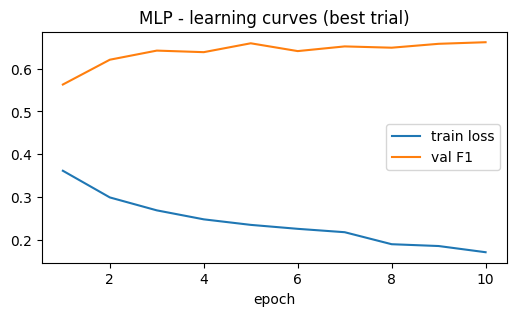

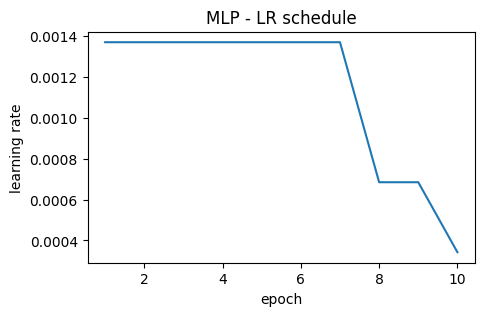

In [13]:
import matplotlib.pyplot as plt

best = study.best_trial

epochs = range(1, len(best.user_attrs["lr_curve"]) + 1)


plt.figure(figsize=(6, 3))

plt.plot(epochs, best.user_attrs["train_loss_curve"], label="train loss")

plt.plot(epochs, best.user_attrs["val_f1_curve"], label="val F1")

plt.xlabel("epoch")
plt.legend()

plt.title("MLP - learning curves (best trial)")

plt.show()


plt.figure(figsize=(5, 3))

plt.plot(epochs, best.user_attrs["lr_curve"])

plt.xlabel("epoch")
plt.ylabel("learning rate")

plt.title("MLP - LR schedule")

plt.show()

 ## 7. Evaluate best MLP on test set

In [14]:
# rebuild test windows
feat = best.user_attrs["features"]
cols = ALL_NUMERIC_COLS if feat == "all_numeric" else FEATURE_SETS[feat]
WIN, STR = best.user_attrs["win_len"], best.user_attrs["stride"]

test_df = SUPER["test_df"]
X_te, y_te = build_windows(test_df, WIN, STR, cols)
test_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_te, dtype=torch.float32),
        torch.tensor(y_te, dtype=torch.float32).unsqueeze(1),
    ),
    batch_size=256,
    shuffle=False,
    pin_memory=True if DEVICE == "cuda" else False,
)

model = MLPClassifier(
    in_dim=X_te.shape[1] * X_te.shape[2],
    hidden1=best.params["hidden1"],
    hidden2=best.params["hidden2"],
    dropout=best.params["dropout"],
).to(DEVICE)
model.load_state_dict(torch.load(best.user_attrs["ckpt"], map_location=DEVICE))
model.eval()

MLPClassifier(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2040, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=64, out_features=1, bias=True)
  )
)

Evaluation

In [15]:
all_pred, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb.to(DEVICE))
        all_pred.extend((torch.sigmoid(logits) > 0.5).cpu().numpy().ravel())
        all_true.extend(yb.numpy().ravel())
y_pred = np.array(all_pred, dtype=int)
y_true = np.array(all_true, dtype=int)

Metrics

In [16]:
cm = confusion_matrix(y_true, y_pred)  # [[TN FP] [FN TP]]
TN, FP, FN, TP = cm.ravel()

acc = accuracy_score(y_true, y_pred)
recall = TP / (TP + FN + 1e-12)  # sensitivity / TPR
spec = TN / (TN + FP + 1e-12)  # specificity / TNR
prec = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Confusion matrix (rows: true, cols: pred)")
print(cm, "\n")
print(f"Accuracy     : {acc :.3f}")
print(f"Recall (TPR) : {recall :.3f}")
print(f"Specificity  : {spec :.3f}")
print(f"Precision    : {prec :.3f}")
print(f"F1-score     : {f1 :.3f}")

Confusion matrix (rows: true, cols: pred)
[[20076  6689]
 [ 4058  8764]] 

Accuracy     : 0.729
Recall (TPR) : 0.684
Specificity  : 0.750
Precision    : 0.567
F1-score     : 0.620


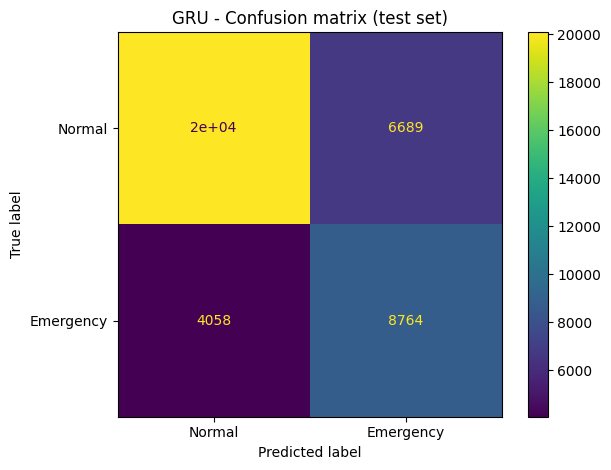

In [17]:
fig1, ax1 = plt.subplots()
ConfusionMatrixDisplay(cm, display_labels=["Normal", "Emergency"]).plot(ax=ax1)
ax1.set_title("GRU - Confusion matrix (test set)")
plt.tight_layout()
plt.show()

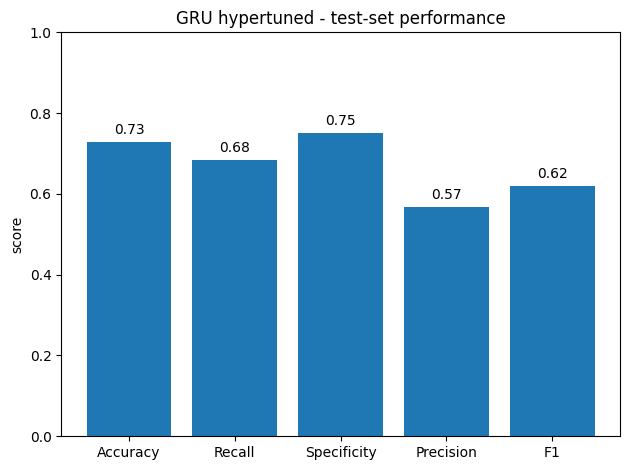

In [18]:
fig2, ax2 = plt.subplots()
metrics = [acc, recall, spec, prec, f1]
labels = ["Accuracy", "Recall", "Specificity", "Precision", "F1"]
ax2.bar(labels, metrics)
ax2.set_ylim(0, 1)
ax2.set_ylabel("score")
ax2.set_title("GRU hypertuned - test-set performance")
for idx, v in enumerate(metrics):  # annotate bars
    ax2.text(idx, v + 0.02, f"{v:.2f}", ha="center")
plt.tight_layout()
plt.show()